## Import Libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

## Load Dataset

In [2]:
df = pd.read_csv('cirrhosis.csv')
display(df.head(5))

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


## Explore and Clean Data

#### Initial preview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

In [4]:
df.drop('ID', inplace=True, axis=1)
display(df.head(5))

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [5]:
df.isna().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [6]:
df.nunique()

N_Days           399
Status             3
Drug               2
Age              344
Sex                2
Ascites            2
Hepatomegaly       2
Spiders            2
Edema              3
Bilirubin         98
Cholesterol      201
Albumin          154
Copper           158
Alk_Phos         295
SGOT             179
Tryglicerides    146
Platelets        243
Prothrombin       48
Stage              4
dtype: int64

#### Handle missing data

First 312 cases participated in the D-penicillamine treatment while the rest were untreated. Let's filter the untreated patients since limited data was obtained. In addition, there were a couple of missing data in the cholesterol and tryglicerides column so we will remove those patients to prevent any downstream issues. After removal, the final data count changed from `418` to `276`.

In [7]:
# Filter non-treated patients
df_cleaned = df.dropna(subset=['Drug'])
df_cleaned.isnull().sum()

N_Days            0
Status            0
Drug              0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin         0
Cholesterol      28
Albumin           0
Copper            2
Alk_Phos          0
SGOT              0
Tryglicerides    30
Platelets         4
Prothrombin       0
Stage             0
dtype: int64

In [8]:
# Filter out all null values
df_cleaned = df_cleaned.dropna()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 311
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         276 non-null    int64  
 1   Status         276 non-null    object 
 2   Drug           276 non-null    object 
 3   Age            276 non-null    int64  
 4   Sex            276 non-null    object 
 5   Ascites        276 non-null    object 
 6   Hepatomegaly   276 non-null    object 
 7   Spiders        276 non-null    object 
 8   Edema          276 non-null    object 
 9   Bilirubin      276 non-null    float64
 10  Cholesterol    276 non-null    float64
 11  Albumin        276 non-null    float64
 12  Copper         276 non-null    float64
 13  Alk_Phos       276 non-null    float64
 14  SGOT           276 non-null    float64
 15  Tryglicerides  276 non-null    float64
 16  Platelets      276 non-null    float64
 17  Prothrombin    276 non-null    float64
 18  Stage     

#### Feature and target variables

In [9]:
# Turn target variable to int
df_cleaned['Stage'] = df_cleaned['Stage'].astype(int)

# Distinguish feature and target variables
X = df_cleaned.iloc[:, :-1]
y = df_cleaned.iloc[:, -1].astype(int)

print(df_cleaned.head(5))

   N_Days Status             Drug    Age Sex Ascites Hepatomegaly Spiders  \
0     400      D  D-penicillamine  21464   F       Y            Y       Y   
1    4500      C  D-penicillamine  20617   F       N            Y       Y   
2    1012      D  D-penicillamine  25594   M       N            N       N   
3    1925      D  D-penicillamine  19994   F       N            Y       Y   
4    1504     CL          Placebo  13918   F       N            Y       Y   

  Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     Y       14.5        261.0     2.60   156.0    1718.0  137.95   
1     N        1.1        302.0     4.14    54.0    7394.8  113.52   
2     S        1.4        176.0     3.48   210.0     516.0   96.10   
3     S        1.8        244.0     2.54    64.0    6121.8   60.63   
4     N        3.4        279.0     3.53   143.0     671.0  113.15   

   Tryglicerides  Platelets  Prothrombin  Stage  
0          172.0      190.0         12.2      4  
1           88.0

#### Transform feature variables

In [10]:
# Get dummy variables for categorical features
X = pd.get_dummies(X)
print(X.head(3))

   N_Days    Age  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     400  21464       14.5        261.0     2.60   156.0    1718.0  137.95   
1    4500  20617        1.1        302.0     4.14    54.0    7394.8  113.52   
2    1012  25594        1.4        176.0     3.48   210.0     516.0   96.10   

   Tryglicerides  Platelets  ...  Sex_M  Ascites_N  Ascites_Y  Hepatomegaly_N  \
0          172.0      190.0  ...      0          0          1               0   
1           88.0      221.0  ...      0          1          0               0   
2           55.0      151.0  ...      1          1          0               1   

   Hepatomegaly_Y  Spiders_N  Spiders_Y  Edema_N  Edema_S  Edema_Y  
0               1          0          1        0        0        1  
1               1          0          1        1        0        0  
2               0          1          0        0        1        0  

[3 rows x 27 columns]


## Data Visualization

#### Distribution plots

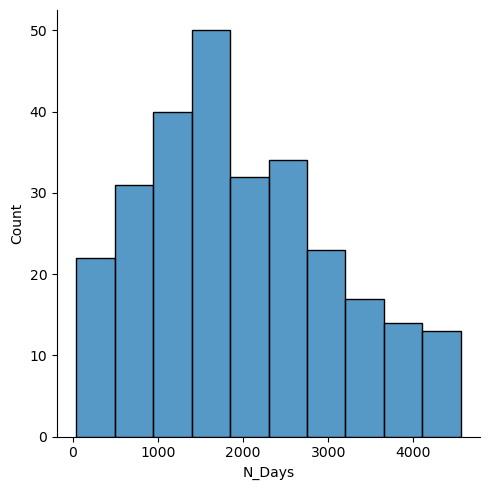

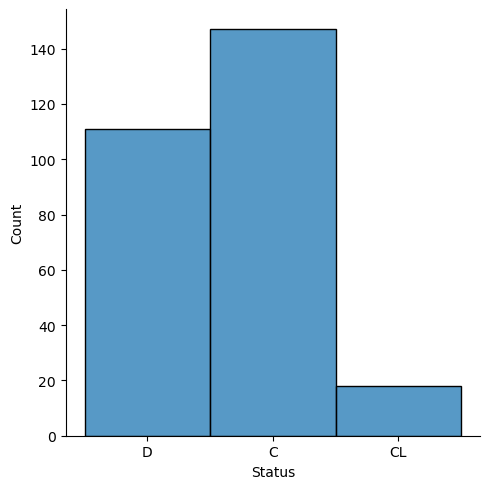

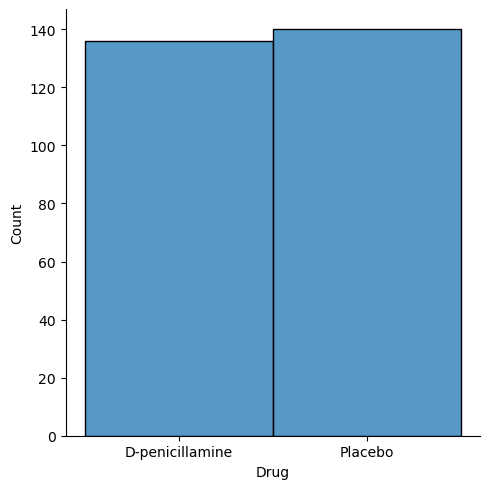

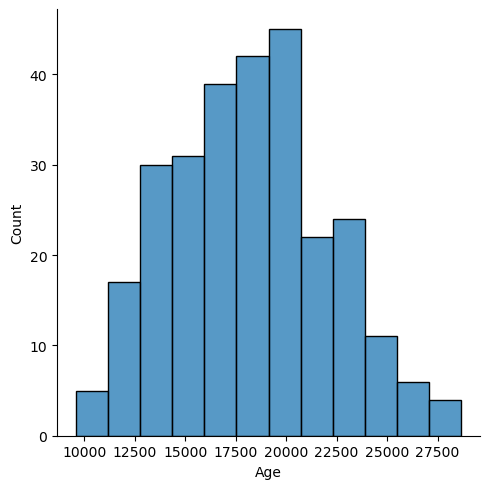

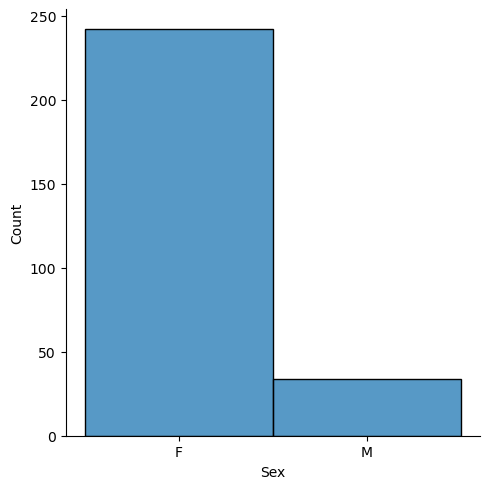

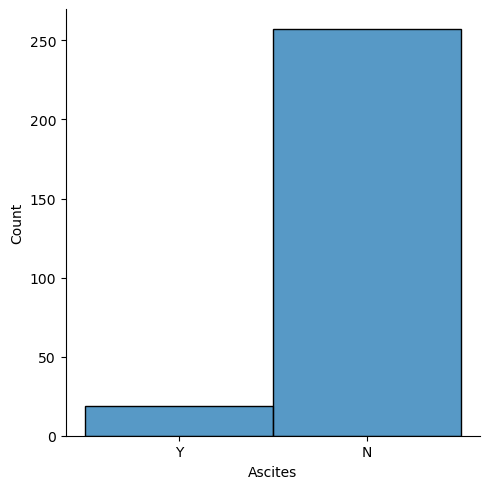

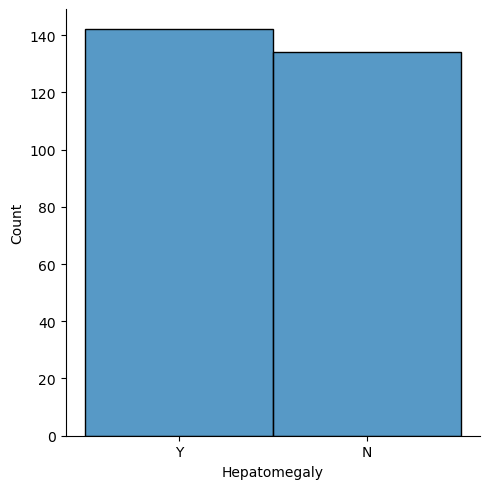

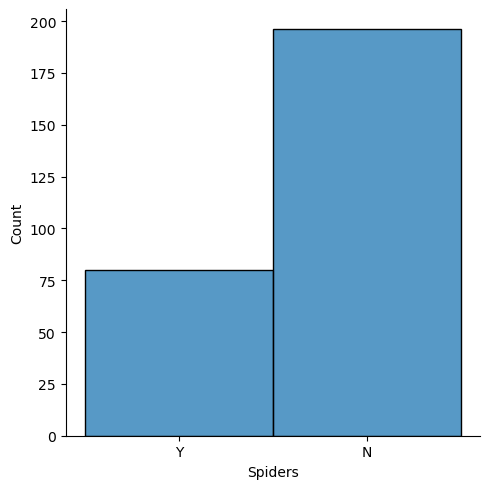

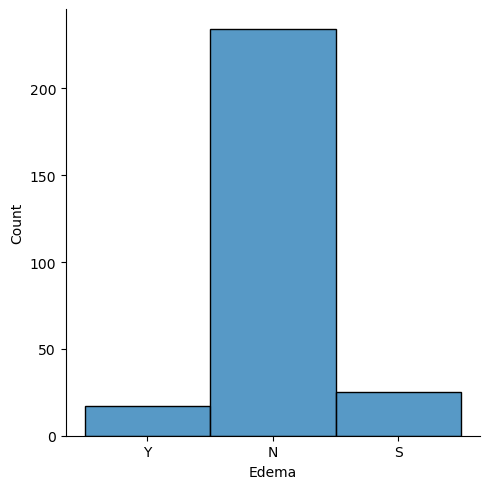

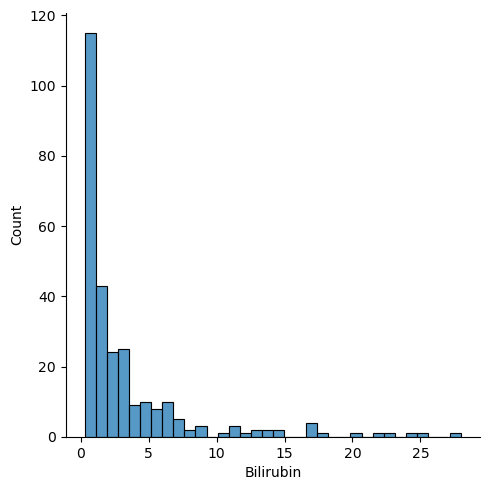

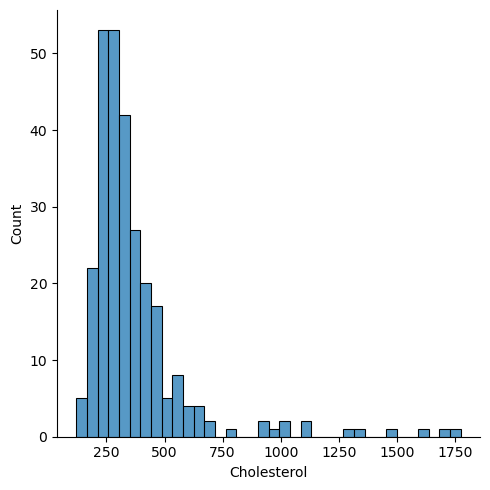

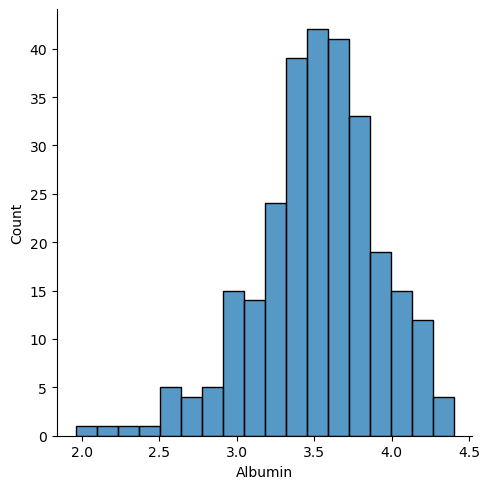

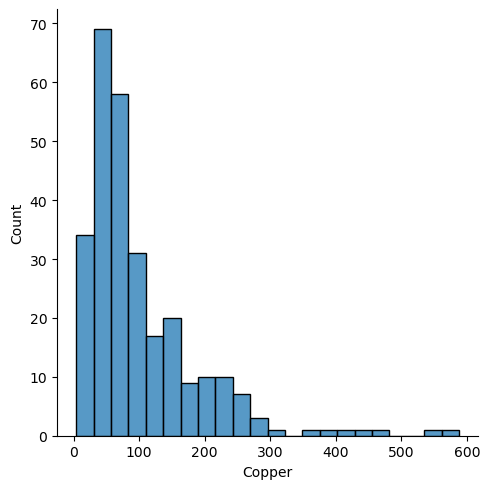

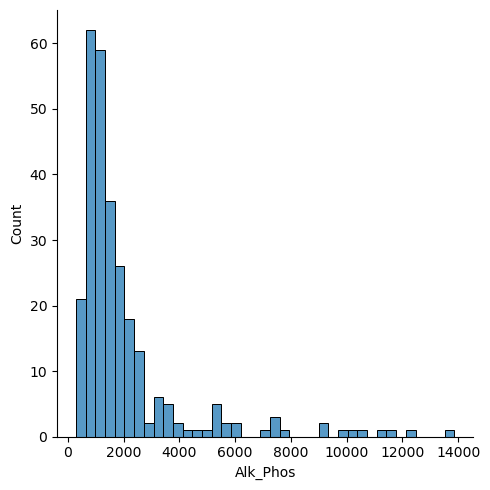

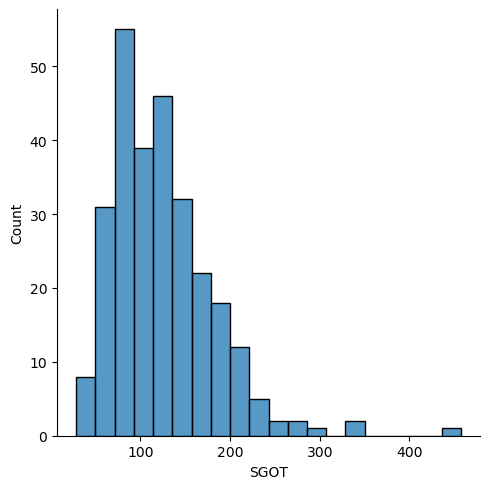

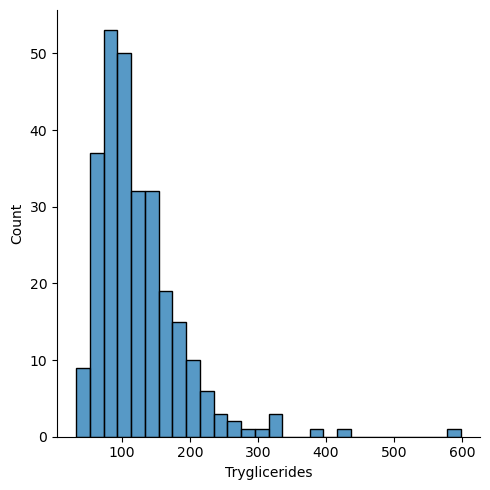

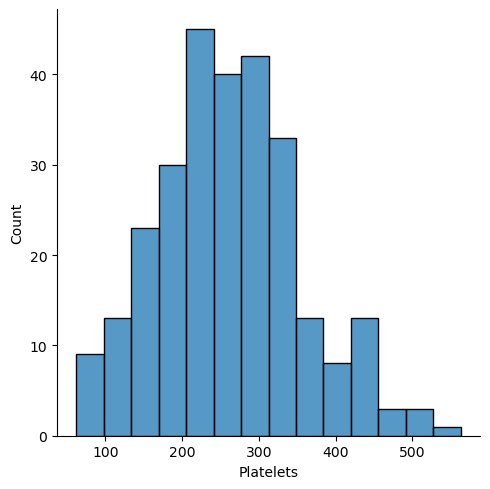

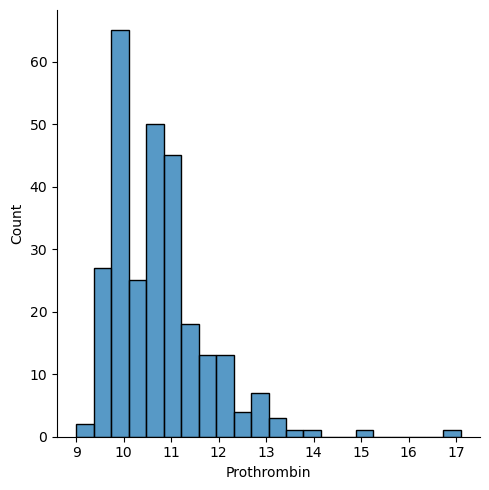

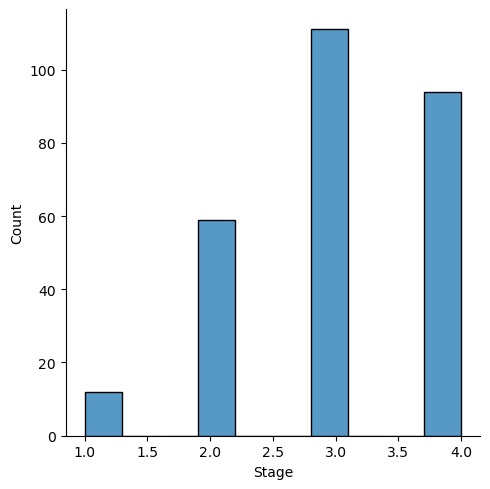

In [11]:
def get_distribution_plots(variables, df):
    for variable in variables:
            sns.displot(df[variable])
            plt.show()
        
features = df_cleaned.columns
get_distribution_plots(features, df_cleaned)

#### Correlation matrix

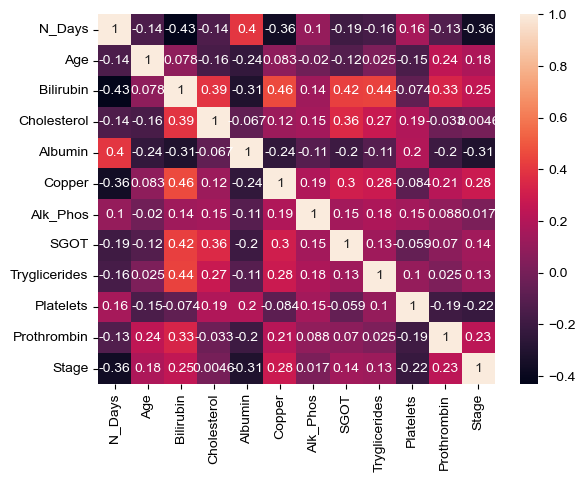

In [12]:
corr = df_cleaned.corr()

sns.heatmap(corr, annot=True)
sns.set(rc={"figure.figsize": (30, 20)})
plt.show()

## Preprocess Data

#### Split into train/test sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

#### Feature selection

In [14]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state = 1)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [15]:
import time

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute importances: {elapsed_time:.3} seconds")

Elapsed time to compute importances: 0.00898 seconds


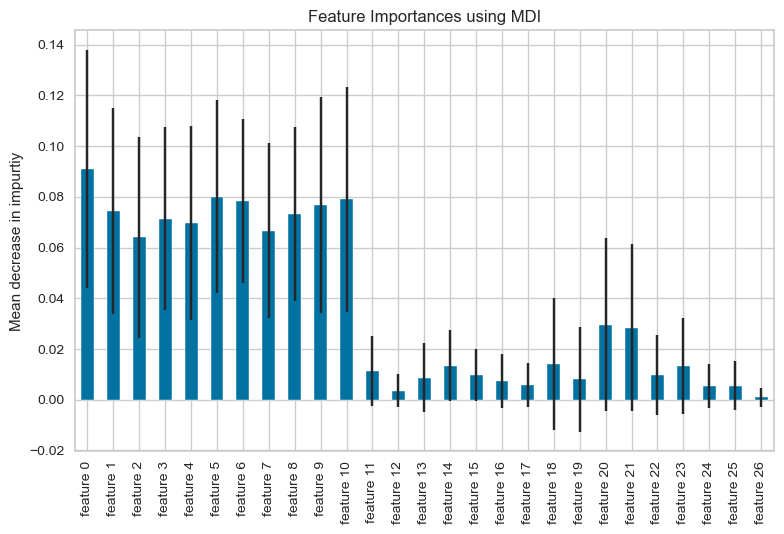

In [27]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importances using MDI")
ax.set_ylabel("Mean decrease in impurtiy")
fig.tight_layout()
plt.show()

In [30]:
# del feature_names[11:20]
# del feature_names[13:]

# print(feature_names)

['feature 0', 'feature 1', 'feature 2', 'feature 3', 'feature 4', 'feature 5', 'feature 6', 'feature 7', 'feature 8', 'feature 9', 'feature 10', 'feature 20', 'feature 21']


In [38]:
list_1 = X.columns[0:11]
list_2 = X.columns[20:22]

filtered_features = list_1 + list_2
display(filtered_Features)

ValueError: operands could not be broadcast together with shapes (11,) (2,) 

#### Handle imbalanced data

To handle imbalanced data, we can use sampling method called SMOTE (which stands for **S**ynthetic **M**inority **O**ver-sampling **T**echnique).

(Note: each value corresponds to specific stage of liver cirrhosis)

In [31]:
from collections import Counter

# Instantiate SMOTE 
sm = SMOTE(random_state=1)

# Fit training data
X_train_sampled, y_train_sampled = sm.fit_resample(X_train, y_train)

# Check resampled dataset shape
print("Resampled dataset shape: %s" % Counter(y_train_sampled))

Resampled dataset shape: Counter({4: 86, 3: 86, 1: 86, 2: 86})


#### Create model dataframe

In [32]:
# Concatenate sampled training data
train_df = pd.concat([X_train_sampled, y_train_sampled], axis=1)
train_df = train_df.rename(columns={0: "Stage"})
display(train_df.head(5))

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Stage
0,2598,19544,1.1,257.0,3.36,43.0,1080.0,106.95,73.0,128.0,...,1,0,0,1,1,0,1,0,0,4
1,1297,18719,7.3,426.0,3.93,262.0,2424.0,145.70,218.0,252.0,...,1,0,0,1,1,0,1,0,0,3
2,191,24803,1.3,151.0,3.08,73.0,1112.0,46.50,49.0,213.0,...,0,1,0,1,1,0,0,0,1,4
3,673,20555,3.4,271.0,3.63,464.0,1376.0,120.90,55.0,173.0,...,1,0,1,0,0,1,1,0,0,4
4,2386,18460,6.0,614.0,3.70,158.0,5084.4,206.40,93.0,362.0,...,1,0,1,0,1,0,1,0,0,1


## Comparing Models

In [33]:
# Setup pycaret
from pycaret.classification import *
s = setup(data=train_df, target='Stage')

,Description,Value
0,Session id,8041
1,Target,Stage
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2, 4: 3"
4,Original data shape,"(344, 28)"
5,Transformed data shape,"(344, 28)"
6,Transformed train set shape,"(240, 28)"
7,Transformed test set shape,"(104, 28)"
8,Numeric features,27
9,Preprocess,True


In [20]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6917,0.8976,0.6917,0.6996,0.6744,0.5889,0.5997,0.0930
lightgbm,Light Gradient Boosting Machine,0.6708,0.8623,0.6708,0.6792,0.6664,0.5611,0.5661,0.1340
lda,Linear Discriminant Analysis,0.6625,0.8495,0.6625,0.6666,0.6484,0.5500,0.5591,0.0170
gbc,Gradient Boosting Classifier,0.6583,0.8720,0.6583,0.6733,0.6505,0.5444,0.5529,0.1950
et,Extra Trees Classifier,0.6583,0.8713,0.6583,0.6533,0.6425,0.5444,0.5519,0.0780
xgboost,Extreme Gradient Boosting,0.6458,0.8604,0.6458,0.6516,0.6316,0.5278,0.5350,0.0640
qda,Quadratic Discriminant Analysis,0.6417,0.8407,0.6417,0.7693,0.6041,0.5222,0.5929,0.0170
ridge,Ridge Classifier,0.6208,0.0000,0.6208,0.6307,0.5966,0.4944,0.5071,0.0140
nb,Naive Bayes,0.5792,0.8370,0.5792,0.5785,0.5482,0.4389,0.4538,0.0160
ada,Ada Boost Classifier,0.5667,0.7669,0.5667,0.5687,0.5237,0.4222,0.4472,0.0400


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

## Random Forest

#### Create model

In [21]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8333,0.9317,0.8333,0.8571,0.8205,0.7778,0.7888
1,0.7917,0.9537,0.7917,0.8214,0.7821,0.7222,0.7325
2,0.7917,0.9468,0.7917,0.7929,0.7867,0.7222,0.7256
3,0.7083,0.9340,0.7083,0.6935,0.6808,0.6111,0.6243
4,0.7083,0.8692,0.7083,0.8006,0.6605,0.6111,0.6516
5,0.5417,0.8472,0.5417,0.5071,0.5210,0.3889,0.3907
6,0.5833,0.8576,0.5833,0.5643,0.5645,0.4444,0.4497
7,0.7083,0.8831,0.7083,0.6979,0.6952,0.6111,0.6168
8,0.5833,0.8877,0.5833,0.6000,0.5750,0.4444,0.4573


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=2618, verbose=0, warm_start=False)


#### Tune model

In [23]:
tuned_rf = tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7083,0.9097,0.7083,0.6994,0.6844,0.6111,0.6213
1,0.7917,0.9398,0.7917,0.8042,0.7900,0.7222,0.7273
2,0.7500,0.9329,0.7500,0.7580,0.7412,0.6667,0.6745
3,0.6667,0.9398,0.6667,0.6351,0.6238,0.5556,0.5759
4,0.6667,0.8403,0.6667,0.7375,0.6096,0.5556,0.5877
5,0.5833,0.8634,0.5833,0.5083,0.5322,0.4444,0.4585
6,0.6667,0.8333,0.6667,0.6792,0.6501,0.5556,0.5675
7,0.7500,0.8819,0.7500,0.7536,0.7491,0.6667,0.6682
8,0.7083,0.8542,0.7083,0.7417,0.6992,0.6111,0.6304


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


#### Plot model

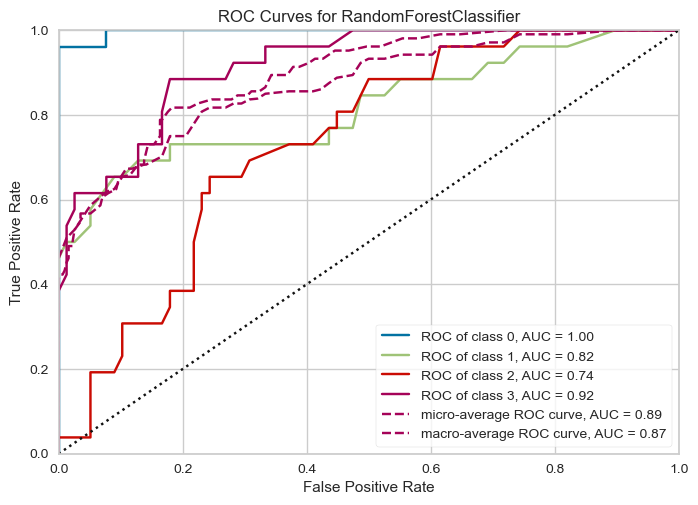

In [24]:
# AUC-ROC curve
plot_model(tuned_rf)

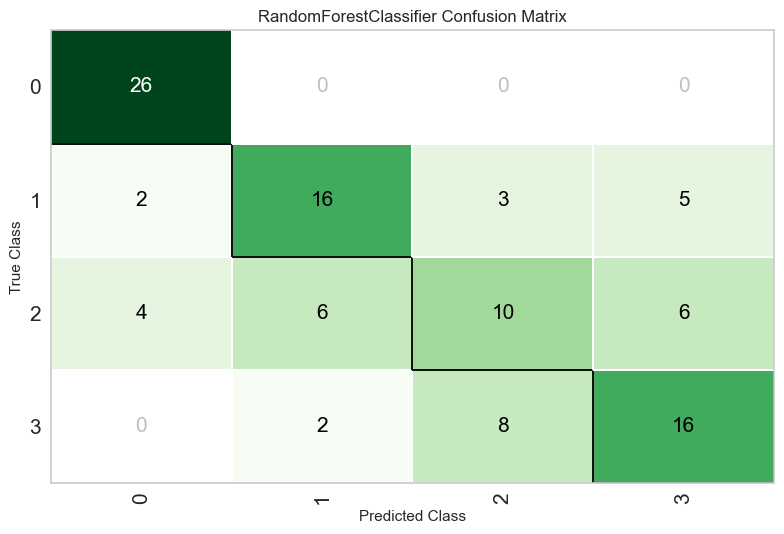

In [25]:
# Confusion matrix
plot_model(tuned_rf, plot = 'confusion_matrix')

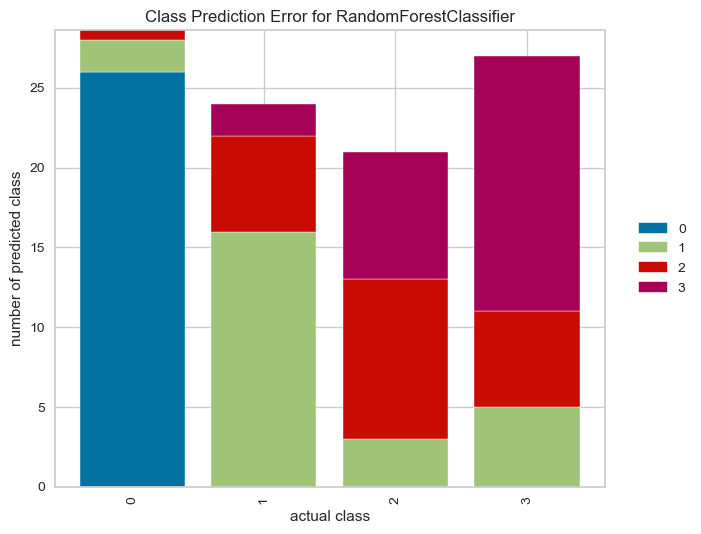

In [26]:
plot_model(tuned_rf, plot = 'error')